## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

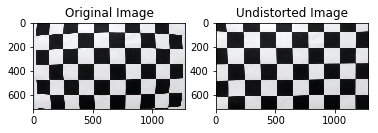

In [1]:
from find_lane import *
%matplotlib qt
%matplotlib inline 

# Calibrate using checkerboard
calib_imgs = glob.glob('./camera_cal/*.jpg')
example_img = cv2.imread(calib_imgs[0])
img_size = (example_img.shape[1], example_img.shape[0])

objpoints, imgpoints = find_obj_img_point_pairs(calib_imgs, 9, 6)
camera_matrix, dist_coeffs = calibrate(objpoints, imgpoints, img_size)

# Show undistort example
example_undistorted = cv2.undistort(example_img, camera_matrix, dist_coeffs, None, camera_matrix)

plt.subplot(1, 2, 1)
plt.imshow(example_img)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(example_undistorted)
plt.title("Undistorted Image")

C:\Users\Peter\Miniconda3\envs\carnd-term1\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


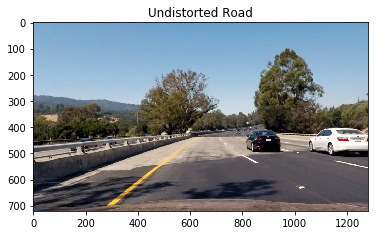

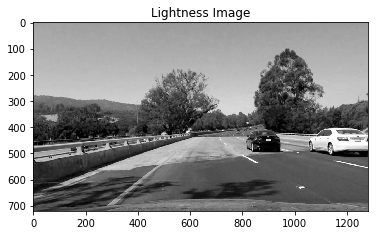

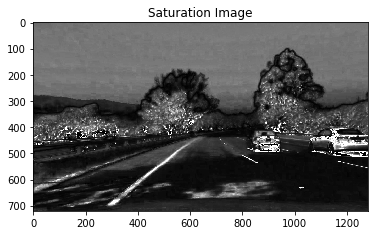

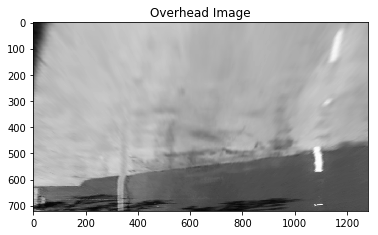

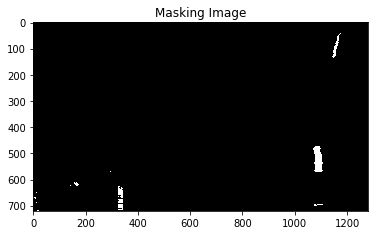

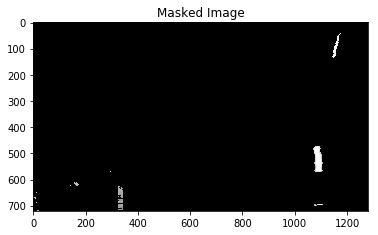

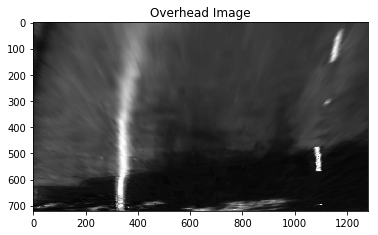

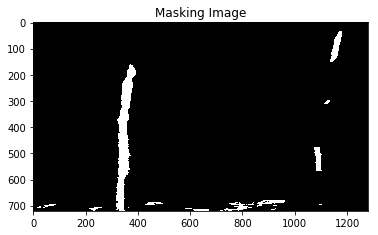

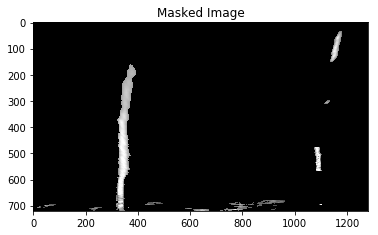

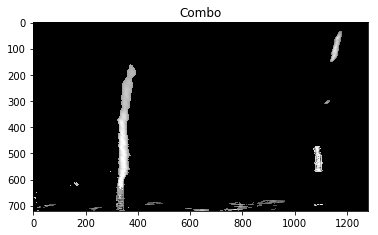

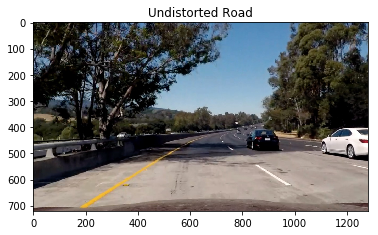

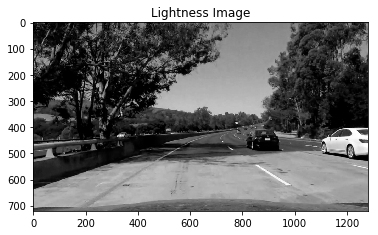

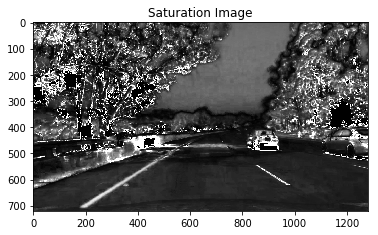

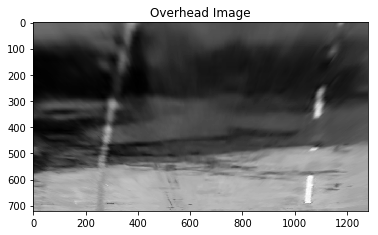

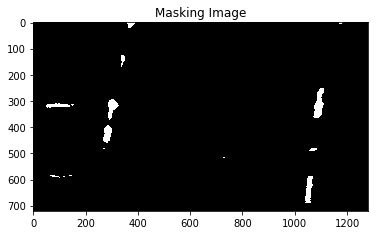

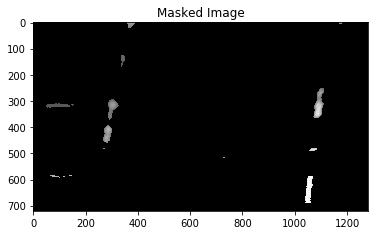

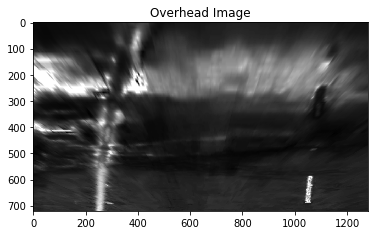

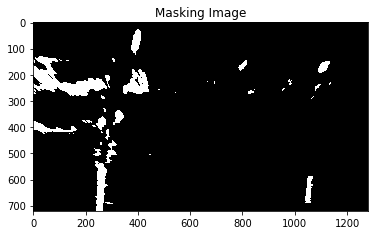

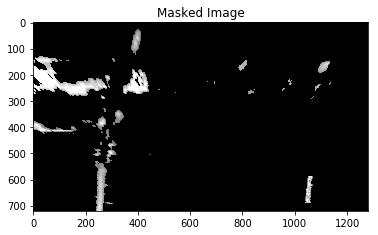

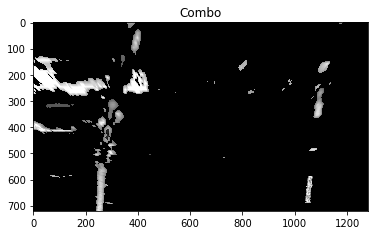

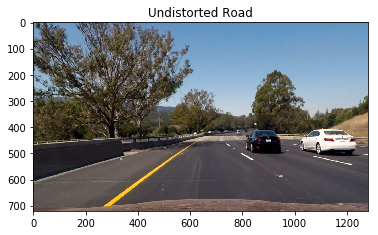

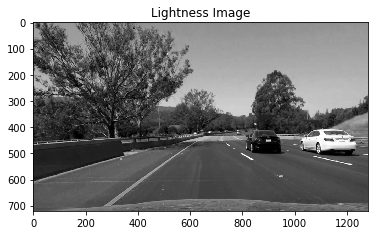

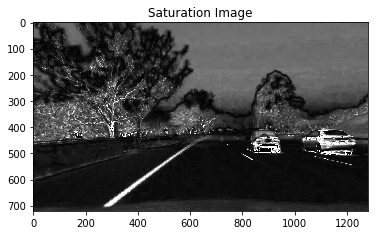

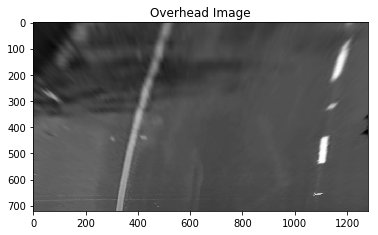

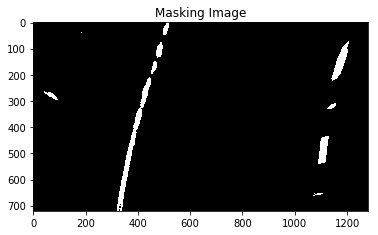

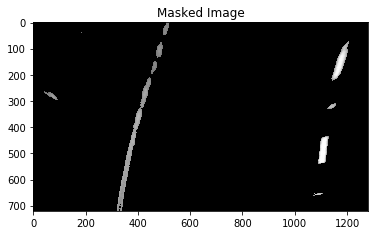

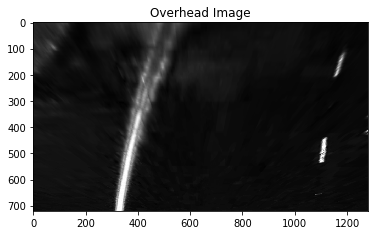

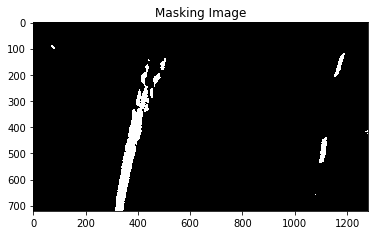

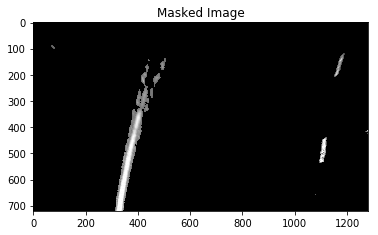

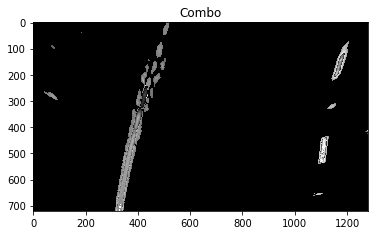

In [28]:
def mask_lanes(img):
    # Transform to overhead image
    dy, dx = img.shape[0:2]
    M_trans = getOverheadTransform(dx, dy)
    overhead_img = cv2.warpPerspective(img, M_trans, (dx, dy))
    if True:
        # Show overhead image
        plt.figure()
        plt.imshow(overhead_img, cmap='gray')
        plt.title("Overhead Image")

    mask = cv2.adaptiveThreshold(
        overhead_img, 
        maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY, 
        blockSize=411, 
        C=-50)
    
    if True:
        # Show binary image
        plt.figure()
        plt.imshow(mask, cmap='gray')
        plt.title("Masking Image")
    
    overhead_img[mask == 0] = 0
    if True:
        # Show binary image
        plt.figure()
        plt.imshow(overhead_img, cmap='gray')
        plt.title("Masked Image")
        
    return overhead_img

def pipeline(img, cam_matrix, distortion_coeffs, verbose=True):
    # Undistort
    img = cv2.undistort(img, cam_matrix, distortion_coeffs, None, cam_matrix)
    if True:
        # Show undistorted road
        plt.figure()
        plt.imshow(img)
        plt.title("Undistorted Road")

    # Change color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lightness = hls[:, :, 1]
    saturation = hls[:, :, 2]

    if True:
        # Show lightness image
        plt.figure()
        plt.imshow(lightness, cmap='gray')
        plt.title("Lightness Image")
        # Show saturation image
        plt.figure()
        plt.imshow(saturation, cmap='gray')
        plt.title("Saturation Image")
    
    # Mask lanes
    lightness_masked = mask_lanes(lightness)
    saturation_masked = mask_lanes(saturation)
    
    total = lightness_masked + saturation_masked
    plt.figure()
    plt.imshow(total, cmap='gray')
    plt.title('Combo')

test_imgs = glob.glob('./test_images/*.jpg')
for imgf in test_imgs[-3:]:
    img = plt.imread(imgf)
    pipeline(img, camera_matrix, dist_coeffs)